In [21]:
import sys
import pandas as pd
import numpy as np
import os
from os.path import join
from matplotlib import pyplot as plt
from collections import OrderedDict
from collections import defaultdict
import ast
import gc
import Bio.PDB
from Bio import SeqIO
from IPython.display import display
from collections import Counter 
import itertools
from IPython.html.widgets.widget_float import FloatProgress

%matplotlib inline
notebook_prefix = 'ks01'

## Orienting

In [2]:
def find_folder_upstream(folder_name, max_iterations=50):
    current_folder = os.getcwd()
    counter = 0
    while os.path.basename(current_folder) != folder_name and counter < max_iterations:
        current_folder = os.path.dirname(current_folder)
        counter += 1
    if not counter < max_iterations:
        return None
    return current_folder

In [3]:
root_folder_name = 'HIS3InterspeciesEpistasis'
root_folder = find_folder_upstream(root_folder_name)
if not root_folder:
    print 'Did not find root folder for our github repository.\nPlease run "ks01" notebook from a script inside the HIS3InterspeciesEpistasis folder!'

data_folder = os.path.join(root_folder, 'Data', '')
small_tables_folder = os.path.join(root_folder, 'Data_Small_Tables', '')
analysis_folder = os.path.join(root_folder, 'Analysis', '')
karen_folder = os.path.join(analysis_folder, 'Karen', '')
figures_folder = os.path.join(karen_folder, 'figures', '')
files_dump_folder = os.path.join(karen_folder, 'files_dump', '')
structure_predictions_folder = os.path.join(files_dump_folder, 'structure_predictions', '')
pymol_sessions_folder = os.path.join(files_dump_folder, 'structure_visualizations/pymol_sessions/', '')

## General stuff

In [4]:
old_dir = os.getcwd()
os.chdir(karen_folder)
%run 'functions_dump.py'
os.chdir(old_dir)
image_counter = Counter()

/Users/karen/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [5]:
segment_colors_list = [('S1','#00aba9'), ('S2','#ff0097'), ('S3','#a200ff'), ('S4','#b8d000'), ('S5','#1ba1e2'), ('S6','#f09609'), 
('S7','#edc951'), ('S8','#cc2a36'), ('S9','#4f372d'), ('S10','#0c457d'), ('S11','#616161'), ('S12','#800080')]
segment_colors = OrderedDict(segment_colors_list)

## Reading the data

In [6]:
def get_segment_long_name_from_file(f):
    return f[:-12]

data_all = OrderedDict()
files = [f for f in os.listdir(data_folder) if '.csv' in f]
for f in sorted(files, key = lambda s: int(s.split('_')[0][1:])):
    data_all[get_segment_long_name_from_file(f)] = pd.read_table(os.path.join(data_folder, f))

In [7]:
title = 'Color code for segments'
plt.figure(figsize=(1, 5))
ax = plt.subplot(111)
plt.tick_params(axis="both", which="both", bottom="off", top="off",  
    labelbottom="off", left="off", right="off", labelleft="off")
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.spines["bottom"].set_visible(False)  
ax.spines["left"].set_visible(False) 

counter = 1
for segment, color in sorted(segment_colors.items(), key=lambda s: int(s[0][1:]), reverse=True):
    plt.plot(counter * np.array([1,1]), color=color, label=segment, lw=3)
    plt.text(1.2, counter, segment, va='center')
    counter += 1
plt.xlim(-0.1, 1.8)
plt.ylim(-0.1, counter + 0.1)
plt.tight_layout()
# save_image(image_counter, title, figures_folder, notebook_prefix)
plt.close()

### Working with positions

In [8]:
def remove_gaps(seq):
    return ''.join([c for c in seq if c != '-'])

def get_wt_position(position_in_alignment):
    truncated_seq = remove_gaps(aligned_Scer[:position_in_alignment+1])
    return len(truncated_seq)

def relative_to_absolute_numbering(mutation, segment, df_with_data):
    display(df_with_data[segment][df_with_data[segment].mut_list == mutation][['mut_list', 'mut_list_Scer']])
    return df_with_data[segment][df_with_data[segment].mut_list == mutation].mut_list_Scer.values[0]

In [9]:
Scer_Uniprot = open(os.path.join(files_dump_folder, 'HIS3_saccharomyces_cerevisiae_from_Uniprot_P06633.txt')).read().rstrip()
alignment_file = os.path.join(small_tables_folder, 'aa_seq.txt')
for seq_record in SeqIO.parse(alignment_file, 'fasta'):
    if seq_record.id == 'Scer':
        aligned_Scer = str(seq_record.seq)
        break
assert remove_gaps(aligned_Scer) == Scer_Uniprot

In [10]:
positions = pd.read_table(os.path.join(small_tables_folder, 'positions.csv'))
positions = positions.set_index('Unnamed: 0').transpose().reset_index()
positions.rename(columns={'index' : 'segment', 'positions':'positions_alignment'}, inplace=True)
positions.reset_index(drop=True, inplace=True)
positions['positions_alignment'] = positions['positions_alignment'].apply(lambda s: ast.literal_eval(s))
positions['positions_Uniprot_P06633'] = positions.positions_alignment.apply(lambda l: [get_wt_position(p) for p in l])
segment_names = positions.segment.values # not explicitly sorted
positions.to_csv(os.path.join(files_dump_folder, 'information_about_segments.csv'), index=False)
positions[:3]

Unnamed: 0,segment,wt1,positions_alignment,len1,len2,start1,end1,wt2,start2,end2,start_Scer,end_Scer,positions_Uniprot_P06633
0,S1,EALGAVRGVK,"[140, 141, 142, 143, 144, 145, 146, 147, 148, ...",10,10,140,149,EALSRAVVDL,160,169,106,135,"[106, 107, 108, 109, 110, 111, 112, 113, 114, ..."
1,S2,SNRPYAVVE,"[170, 171, 172, 173, 174, 175, 176, 177, 178, ...",9,9,170,178,LSCEMIPHF,189,197,136,163,"[136, 137, 138, 139, 140, 141, 142, 143, 144, ..."
2,S3,LGLQREKVGD,"[179, 180, 181, 182, 183, 184, 185, 186, 187, ...",10,7,179,188,LESFAEA,198,204,145,170,"[145, 146, 147, 148, 149, 150, 151, 152, 153, ..."


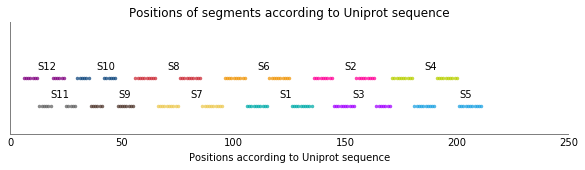

In [11]:
title = 'Positions of segments according to Uniprot sequence'
plot_better(grid='', height=2)
old_y = 2
for row in positions.iterrows():
    for position in row[1].positions_Uniprot_P06633:
        new_y = np.random.choice([1,2])
        while new_y == old_y:
            new_y = np.random.choice([1,2])
    x = row[1].positions_Uniprot_P06633
    plt.plot(x, [new_y for e in x], '.', lw=3, alpha=0.7, label=row[1].segment, color=segment_colors[row[1].segment])
    plt.text(np.median(x), new_y + 0.3, row[1].segment)
    old_y = new_y
plt.ylim(0,4)
plt.yticks([])
plt.xlabel('Positions according to Uniprot sequence')
plt.title(title)

### Keeping only the mutants carrying substitutions (no indels, no mutations in the unmutated "central region")

In [12]:
def count_mutations(muts):
    if not muts > 0:
        return 0
    else:
        return muts.count(':') + 1

In [13]:
data = OrderedDict()
for k,v in data_all.items():
    data[k] = v[(v.middle == 1) & (v.nogap == 1)].copy()
    data[k]['mut_number'] = data[k].mut_list_Scer.apply(count_mutations)

data_natural = OrderedDict()
for k,v in data_all.items():
    data_natural[k] = v[(v.middle == 1) & (v.nogap == 1) & (v.nat_lib == 1)].copy()
    data_natural[k]['mut_number'] = data_natural[k].mut_list_Scer.apply(count_mutations)

### Killing data_all

In [14]:
data_all = None
gc.collect()

144

### Adding from_aa to notation of mutations

In [15]:
def get_full_mutation(mutation):
    if mutation == '' or not mutation > 0:
        return ''
    position = int(mutation[:-1])
    assert Scer_Uniprot[position-1] != mutation[-1]
    return Scer_Uniprot[position-1] + mutation

def convert_to_full_mutations(mut_combination):
    if mut_combination == '' or not mut_combination > 0:
        return ''
    return ':'.join(get_full_mutation(mutation) for mutation in mut_combination.split(':'))
    
for segment in data:
    data[segment]['mut_list_Scer_full'] = data[segment]['mut_list_Scer'].apply(convert_to_full_mutations)

## Amino acid properties table

In [16]:
# amino acid codes
aa_long = ['alanine', 'cysteine', 'aspartic acid', 'glutamic acid', 'phenylalanine', 'glycine', 
           'histidine', 'isoleucine', 'lysine', 'leucine', 'methionine', 'asparagine', 'proline',
           'glutamine', 'arginine', 'serine', 'threonine', 'valine', 'tryptophan', 'tyrosine', 'unknown_aa'] 
aa1 = list("ACDEFGHIKLMNPQRSTVWYX")
aa3 = "ALA CYS ASP GLU PHE GLY HIS ILE LYS LEU MET ASN PRO GLN ARG SER THR VAL TRP TYR XXX".split()
aa123 = dict(zip(aa1, aa3))
aa321 = dict(zip(aa3, aa1))
aa_full_to_1 = dict(zip(aa_long, aa1))
aa_1_to_full = dict(zip(aa1, aa_long))

In [17]:
# Original table http://www.proteinsandproteomics.org/content/free/tables_1/table08.pdf

aa_properties = pd.read_table(os.path.join(files_dump_folder, 'properties_of_amino_acids.csv'), sep=';')

aa_properties['Fraction of buried among this aa'] = aa_properties['Percent buried residues'].apply(lambda s: float(s.split()[0]))
aa_properties['Fraction of buried among all buried'] = aa_properties['Percent buried residues'].apply(lambda s: float(s.split()[1][1:-1]))

aa_properties['Polarity average ranking'] = aa_properties['Ranking of amino acid polarities'].apply(lambda s: float(s.split()[0]))
aa_properties['Polarity ranking (Radzicka and Wolfenden 1988)'] = aa_properties['Ranking of amino acid polarities'].apply(lambda s: float(s.split()[1][1:-1]))

aa_properties['amino_acid'] = aa_properties['Amino acid residue'].apply(lambda s: s.lower())
aa_properties.set_index('amino_acid', inplace=True)

aa_properties.drop(['Unnamed: 8', 'Unnamed: 10', 'Percent buried residues', 'Ranking of amino acid polarities', 'Amino acid residue'], inplace=True, axis=1)
aa_properties = aa_properties.astype(np.float, raise_on_error=False)

quantitative_properties = [p for p in aa_properties.columns if 'pKa' not in p]

def get_aa_properties_by_single_letter_code(aa_1):
    return aa_properties.loc[aa_1_to_full[aa_1]]

## Describing mutations by properties of aa

In [23]:
def aa_property_change(mutation, aa_property):
    assert aa_property in aa_properties.columns.values
    if mutation == '':
        return None
    aa_from = mutation[0]
    position = int(mutation[1:-1])
    aa_to = mutation[-1]
    properties_from = get_aa_properties_by_single_letter_code(aa_from)
    properties_to = get_aa_properties_by_single_letter_code(aa_to)
#     print mutation, properties_to[aa_property], properties_from[aa_property], properties_to[aa_property] - properties_from[aa_property]
    return properties_to[aa_property] - properties_from[aa_property]


precalculated_changes = {}
for aa_property in quantitative_properties:
    precalculated_changes[aa_property] = {}
    for substitution in list(itertools.permutations([aa for aa in aa1 if aa != 'X'], 2)):
        precalculated_changes[aa_property][substitution] = aa_property_change(substitution[0] + '123' + substitution[1], aa_property)        
        
def cumulative_property_change(mut_combination, aa_property, absolute_values=True, use_precalculated=True):
    assert aa_property in aa_properties.columns.values
    if mut_combination == '':
        return None
    changes = []
    if use_precalculated:
        for m in mut_combination.split(':'):
            changes.append(precalculated_changes[aa_property][m[0], m[-1]])
    else:
        for m in mut_combination.split(':'):
            changes.append(aa_property_change(m, aa_property))
    if absolute_values:
        return sum([np.abs(v) for v in changes])
    else:
        return sum(changes)

In [36]:
print 'Calculating changes in properties:'
for p in quantitative_properties:
    print '  ', p
sys.stdout.flush()

f = FloatProgress(min=0, max=len(data.keys()))
display(f)
for segment in data:
    for aa_property in quantitative_properties:
        data[segment]['Abs change in ' + aa_property.lower()] = data[segment]['mut_list_Scer_full'].apply(
            lambda mut_comb: cumulative_property_change(mut_comb, aa_property))
    data[segment].to_hdf(os.path.join(files_dump_folder, 'processed_data', 'Data_dict_%s.hdf' %segment), 'data')
    f.value += 1

Calculating changes in properties:
   Average residue mass (daltons)
   Monoisotopic mass (daltons)
   Occurrence in proteins, %
   Average volume of buried residues, A3
   Van der Waals volume, A3
   Accessible surface area, A2
   Fraction of buried among this aa
   Fraction of buried among all buried
   Polarity average ranking
   Polarity ranking (Radzicka and Wolfenden 1988)


KeyboardInterrupt: 

### Unique single mutations

In [ ]:
unique_single_mutations = OrderedDict()
for segment_name, segment_data in data.items():
    without_wt = segment_data.dropna(subset=['mut_list_Scer'])
    unique_single_mutations[segment_name] = set(':'.join(without_wt.mut_list_Scer.values).split(':'))
unique_single_mutations['all_segments'] = set().union(*unique_single_mutations.values())
print len(unique_single_mutations['all_segments']), 'unique mutations across all segments'

natural_unique_single_mutations = OrderedDict()
for segment_name, segment_data in data_natural.items():
    without_wt = segment_data.dropna(subset=['mut_list_Scer'])
    natural_unique_single_mutations[segment_name] = set(':'.join(without_wt.mut_list_Scer.values).split(':'))
natural_unique_single_mutations['all_segments'] = set().union(*natural_unique_single_mutations.values())
print len(natural_unique_single_mutations['all_segments']), 'natural unique mutations across all segments'

### Singles

In [ ]:
data_singles = OrderedDict()
known_single_mutations = []
for segment_name, segment_data in data.items():
    data_singles[segment_name] = segment_data[segment_data.mut_list.str.count(':') == 0].copy()
    data_singles[segment_name]['position_Scer'] = data_singles[segment_name]['mut_list_Scer'].apply(lambda s: int(s[:-1]))
    known_single_mutations += set(':'.join(data_singles[segment_name].mut_list_Scer.values).split(':'))
positions_with_known_mutations = set([int(m[:-1]) for m in known_single_mutations])
print 'There are %s single mutations with known effects. They are found in %s positions' % (len(known_single_mutations),
                                                                                            len(positions_with_known_mutations))

#### A dictionary containing fitness for every known single mutation

In [ ]:
single_mut_fitness_dict = {}
for segment_data in data_singles.values():
    single_mut_fitness_dict.update(dict(segment_data[['mut_list_Scer', 's']].values))

### Genotypes consisting of mutations with known effects

In [ ]:
wt_fitness = np.median([table[table.mut_number == 0].s.values[0] for table in data.values()])
min_fitness = np.min([table.s.min() for table in data.values()])
max_fitness = np.max([table.s.max() for table in data.values()])

def mut_effect(fitness, wt_fitness=wt_fitness):
    return fitness - wt_fitness

def epistasis(single_mut_fitnesses, fitness_of_combination, wt_fitness=wt_fitness):
    min_mut_effect = mut_effect(min_fitness, wt_fitness=wt_fitness) # has to be inside function for calculating foursome epistasis
    max_mut_effect = mut_effect(max_fitness, wt_fitness=wt_fitness) # has to be inside function for calculating foursome epistasis
    expected_mut_effect = sum([mut_effect(fitness, wt_fitness=wt_fitness) for fitness in single_mut_fitnesses])
    expected_mut_effect = min(expected_mut_effect, max_mut_effect)
    expected_mut_effect = max(expected_mut_effect, min_mut_effect)
    return mut_effect(fitness_of_combination, wt_fitness=wt_fitness) - expected_mut_effect

def epistasis_for_df(df):
    mutations_combination = df['mut_list_Scer']
    fitness_of_combination = df['s']
    single_mut_fitnesses = []
    for single_mutation in mutations_combination.split(':'):
        single_mut_fitnesses.append(single_mut_fitness_dict[single_mutation])
    return epistasis(single_mut_fitnesses, fitness_of_combination)

def foursome_epistasis(panel, wt_mut_combination):
    panel_slice = panel.major_xs(wt_mut_combination).loc['s']
    wt_fitness = panel_slice['wild_type']
    mutA_fitness = panel_slice['mutA']
    mutB_fitness = panel_slice['mutB']
    mutAB_fitness = panel_slice['mutAB']
    return epistasis([mutA_fitness, mutB_fitness], mutAB_fitness, wt_fitness=wt_fitness)

In [ ]:
data_known_mutations_only = OrderedDict()
for segment_name, segment_data in data.items():
    without_wt = segment_data.dropna(subset=['mut_list_Scer'])
    data_known_mutations_only[segment_name] = without_wt[without_wt.mut_list_Scer.apply(
            lambda muts: consists_of_known_mutations(muts, data_singles[segment_name].mut_list_Scer.values))].copy()
    data_known_mutations_only[segment_name]['epistasis'] = data_known_mutations_only[segment_name].apply(epistasis_for_df, axis=1)

# Summary

In [ ]:
print '''
\nNow the following variables are available:

- data: all data as a (sorted) dictionary in the form: 'segment_name': 'segment_data_as_pandas_dataframe'

- unique_single_mutations: a dictionary with all single mutations for every segment

- data_singles: a sorted dictionary in the form: 'segment_name': 'segment_data_as_pandas_dataframe' for genotypes containing a single substitution

- single_mut_fitness_dict: a dictionary in the form: 'single mutation' : 'fitness'

- data_known_mutations_only - a sorted dictionary in the form: 'segment_name': 'segment_data_as_pandas_dataframe', 
but only for those genotypes that consist of mutations with known effects (single mutant is measured).
For this dictionary, epistasis is measured for every genotype.

# # # # # # # # # # # # # # # # #

'''